### Objectives

- Build a strong baseline forecasting model

- Incorporate seasonality & events

- Evaluate using MAE / MAPE

- Create store-level forecasts (hierarchical-ready)

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# If Prophet is not installed
# !pip install prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [9]:
df = pd.read_parquet("data/clean_base_table.parquet")
df.head()

,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,event_name_1,snap_CA,sell_price
0,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,d_1,107,2011-01-29,11101,None,0,1.25
1,FOODS_3_120,FOODS_3,FOODS,CA_1,CA,d_1,0,2011-01-29,11101,None,0,NaN
2,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,d_1,19,2011-01-29,11101,None,0,1.48
3,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,d_1,42,2011-01-29,11101,None,0,1.48
4,FOODS_3_714,FOODS_3,FOODS,CA_1,CA,d_1,49,2011-01-29,11101,None,0,1.48


In [10]:
store_daily = (
    df.groupby(["date", "store_id"])["units_sold"]
    .sum()
    .reset_index()
)

store_daily.head()

,date,store_id,units_sold
0,2011-01-29,CA_1,217
1,2011-01-29,CA_2,195
2,2011-01-30,CA_1,276
3,2011-01-30,CA_2,151
4,2011-01-31,CA_1,111


In [11]:
def prepare_prophet_df(data, store_id):
    df_store = data[data["store_id"] == store_id][["date", "units_sold"]]
    df_store = df_store.rename(columns={"date": "ds", "units_sold": "y"})
    return df_store

In [12]:
def train_val_split(df, split_date):
    train = df[df["ds"] <= split_date]
    val = df[df["ds"] > split_date]
    return train, val

In [13]:
split_date = df["date"].quantile(0.8)
split_date

Timestamp('2015-04-08 00:00:00')

In [14]:
store_id = "CA_1"

prophet_df = prepare_prophet_df(store_daily, store_id)
train_df, val_df = train_val_split(prophet_df, split_date)

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(train_df)

13:22:09 - cmdstanpy - INFO - Chain [1] start processing
13:22:10 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
future = model.make_future_dataframe(periods=len(val_df))
forecast = model.predict(future)

forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1908,2016-04-20,248.355619,93.340932,298.117312,180.174997,315.882115,-53.827832,-53.827832,-53.827832,-48.173143,-48.173143,-48.173143,-5.654689,-5.654689,-5.654689,0.0,0.0,0.0,194.527786
1909,2016-04-21,248.420873,103.645565,312.253732,179.991226,316.324648,-44.346965,-44.346965,-44.346965,-39.683743,-39.683743,-39.683743,-4.663222,-4.663222,-4.663222,0.0,0.0,0.0,204.073908
1910,2016-04-22,248.486128,146.902094,362.965934,179.824250,316.742070,5.583844,5.583844,5.583844,9.315202,9.315202,9.315202,-3.731358,-3.731358,-3.731358,0.0,0.0,0.0,254.069971
1911,2016-04-23,248.551382,219.902898,442.858456,179.657275,317.136974,77.164914,77.164914,77.164914,80.036221,80.036221,80.036221,-2.871308,-2.871308,-2.871308,0.0,0.0,0.0,325.716296
1912,2016-04-24,248.616637,223.019372,441.919089,179.479659,317.509454,82.526817,82.526817,82.526817,84.621212,84.621212,84.621212,-2.094395,-2.094395,-2.094395,0.0,0.0,0.0,331.143454


In [24]:
forecast_val = forecast.set_index("ds").loc[val_df["ds"]]
y_true = val_df["y"].values
y_pred = forecast_val["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")

mask = y_true != 0
mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask])
print(f"Filtered MAPE: {mape*100:.2f}%")

smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
print(f"SMAPE: {smape:.2f}%")

MAE: 51.48
MAPE: 288619393458086656.00%
Filtered MAPE: 32.05%
SMAPE: 26.05%


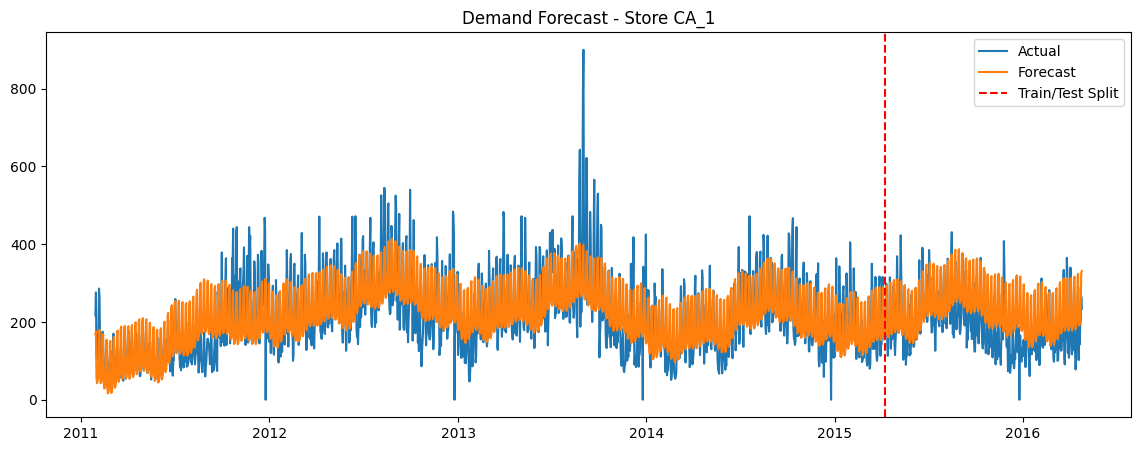

In [17]:
plt.figure(figsize=(14,5))
plt.plot(prophet_df["ds"], prophet_df["y"], label="Actual")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast")
plt.axvline(split_date, color="red", linestyle="--", label="Train/Test Split")
plt.legend()
plt.title(f"Demand Forecast - Store {store_id}")
plt.show()

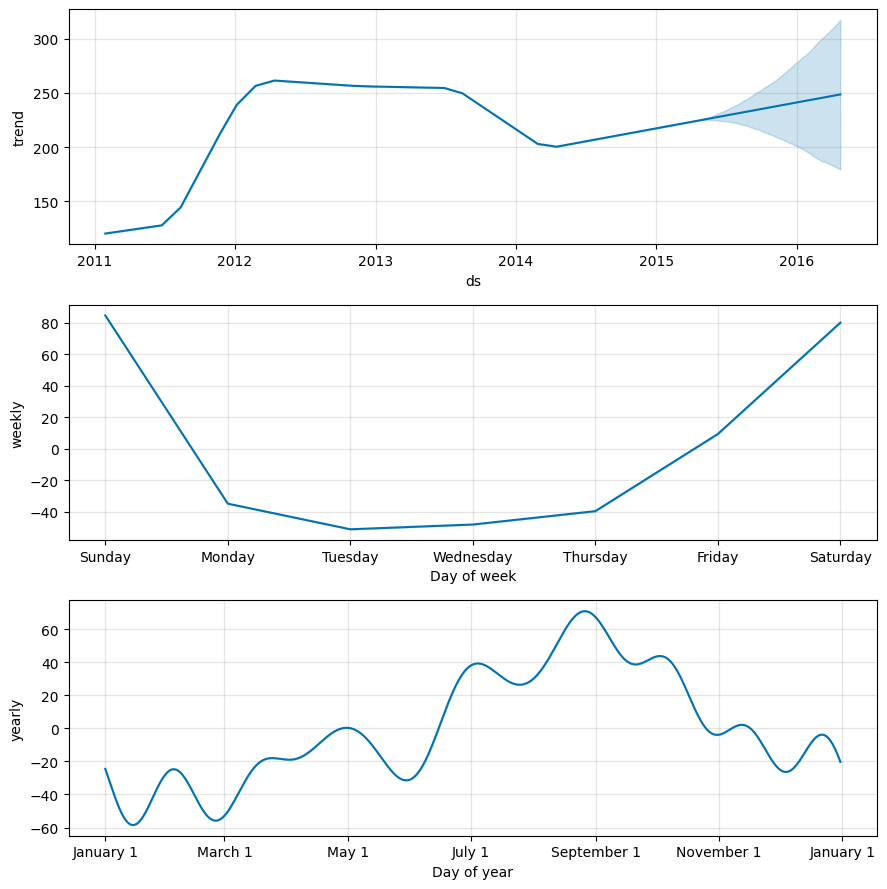

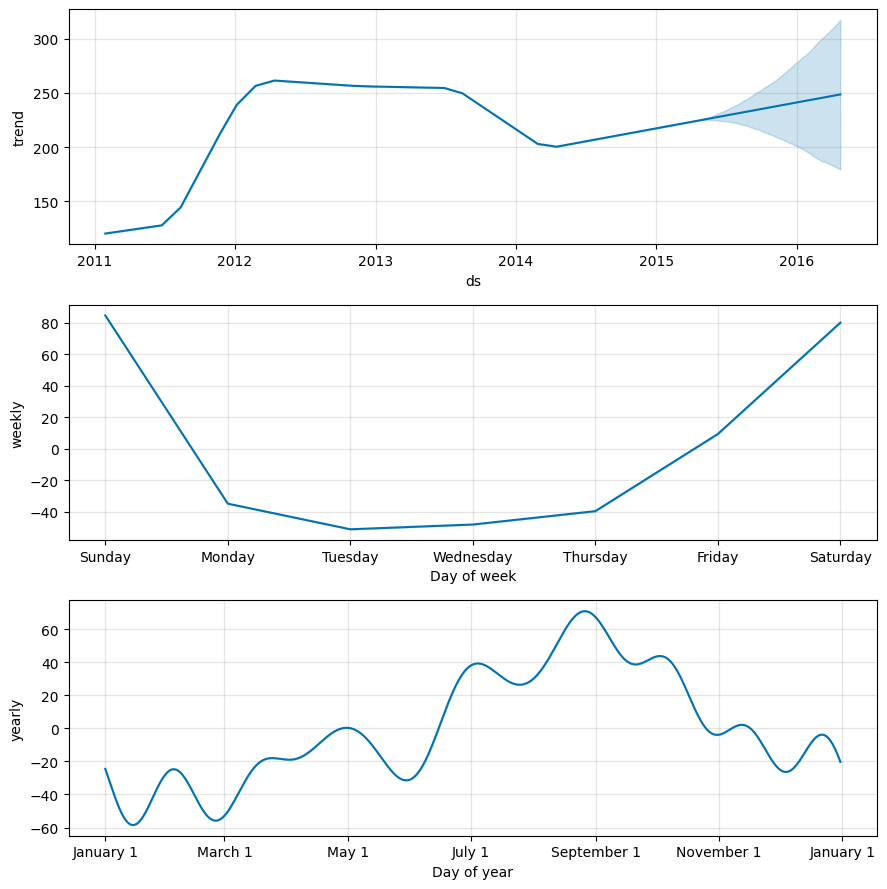

In [19]:
model.plot_components(forecast)

13:23:41 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing


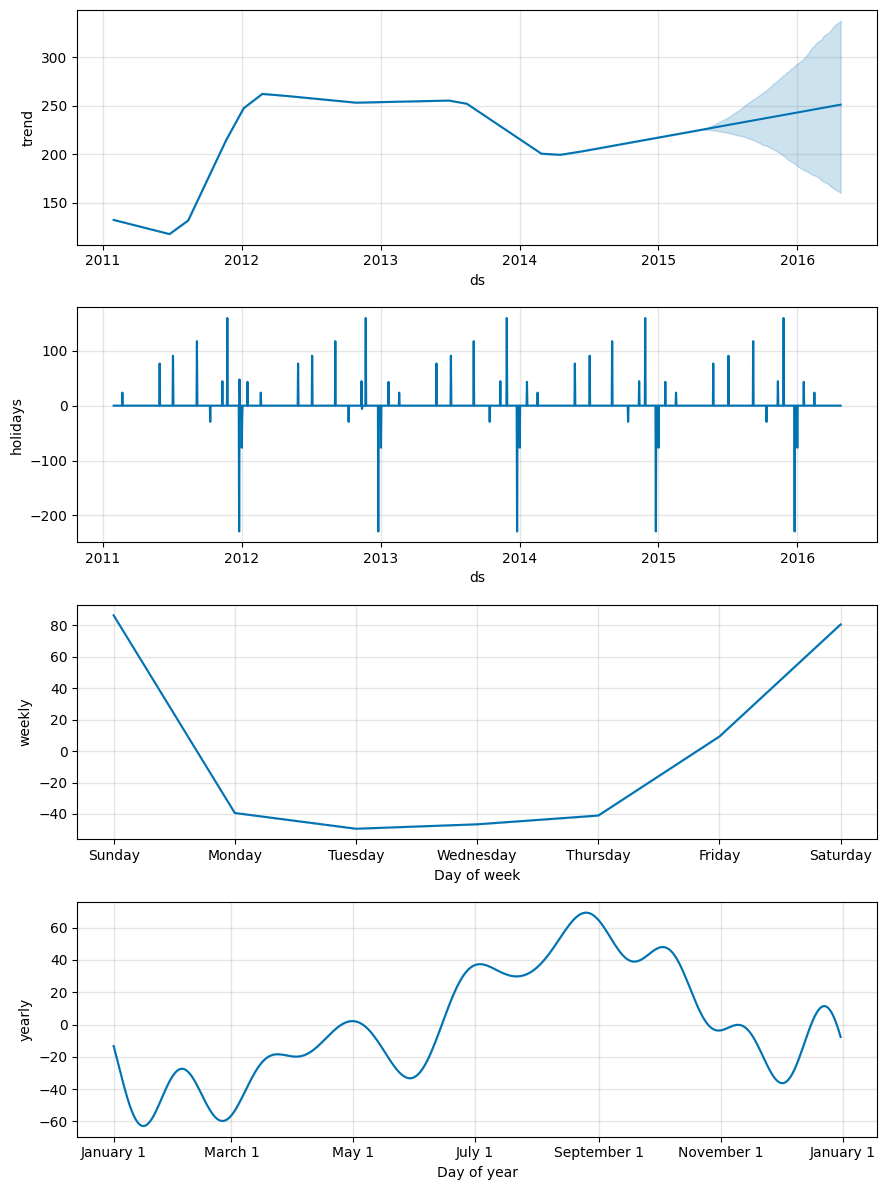

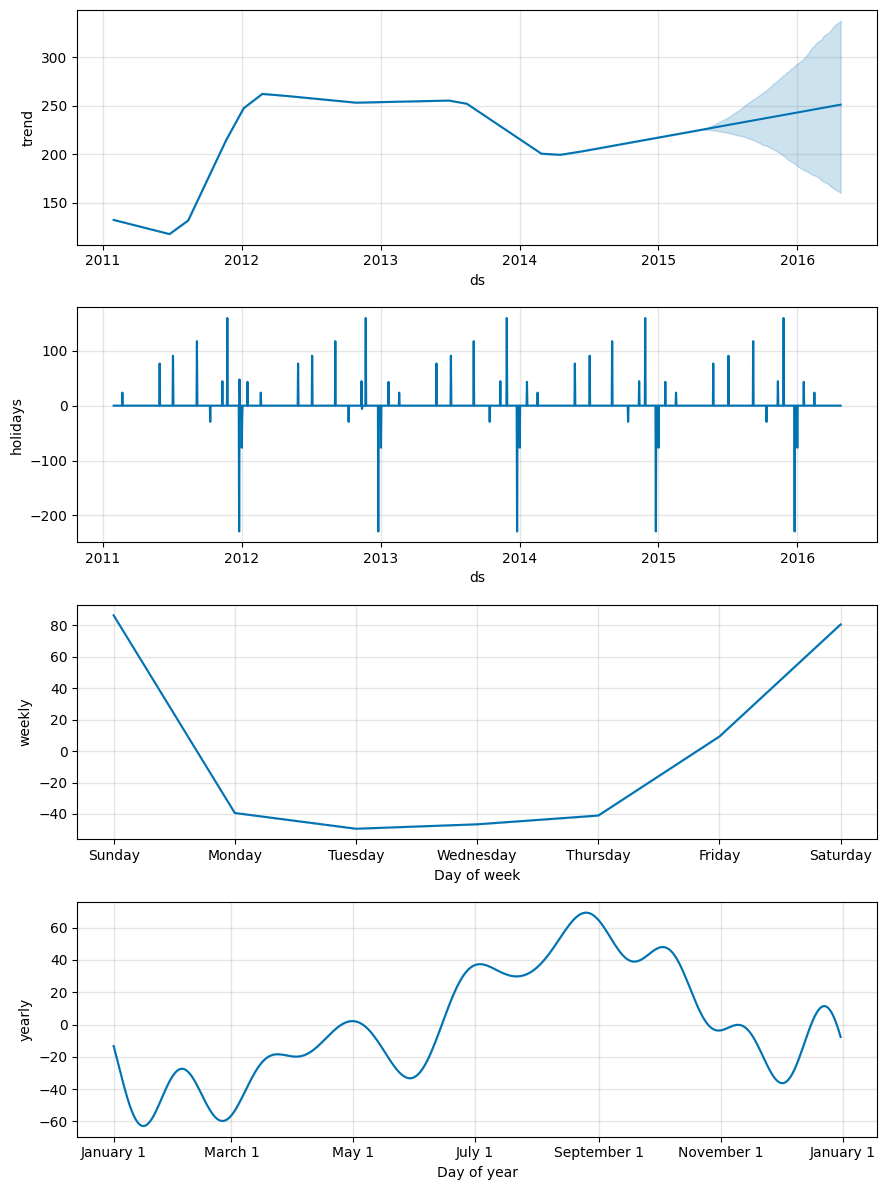

In [20]:
events = (
    df[["date", "event_name_1"]]
    .dropna()
    .drop_duplicates()
    .rename(columns={"date": "ds", "event_name_1": "holiday"})
)

model_events = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True
)

model_events = model_events.add_country_holidays(country_name="US")
model_events.fit(train_df)

forecast_events = model_events.predict(future)
model_events.plot_components(forecast_events)

- Prophet captures strong weekly and yearly seasonality

- Holiday effects significantly impact demand

- Store-level forecasting justifies hierarchical modeling

### Evaluation Metric Considerations

Standard MAPE produced extremely large values due to near-zero actual demand 
on certain days, which is a known limitation of MAPE in retail time series.

To address this:
- Filtered MAPE was computed by excluding zero-demand days
- SMAPE was used as a robust alternative metric

These metrics provide a more reliable assessment of forecast accuracy.